##  🎀 [Day 22](https://adventofcode.com/2018/day/22)

In [0]:
import collections
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg


wet_img = mpimg.imread('day22_wet.jpg')
rocky_img = mpimg.imread('day22_rocky.jpg')
narrow_img = mpimg.imread('day22_narrow.jpg')


def display(target_x, target_y, depth, path=None, offset=(0, 0), figsize=None):
  """Display the cave using some pixel sprites"""
  cave = get_cave(target_x, target_y, depth, offset=offset)
  # add image patches
  image = np.zeros((cave.shape[0] * 16, cave.shape[1] * 16, 3), dtype=np.uint8)
  for i in range(cave.shape[0]):
    for j in range(cave.shape[1]):
      patch = cave[i, j]
      patch = rocky_img if patch == 0 else wet_img if patch == 1 else narrow_img
      image[i * 16: (i + 1) * 16, j * 16: (j + 1) * 16] = patch
  # Add border around the target
  image[16 * target_y, 16 * target_x: 16 * (target_x + 1)] = (0, 255, 0)
  image[16 * (target_y + 1) - 1, 16 * target_x: 16 * (target_x + 1)] = (0, 255, 0)
  image[16 * target_y: 16 * (target_y + 1), 16 * target_x] = (0, 255, 0)
  image[16 * target_y: 16 * (target_y + 1), 16 * (target_x + 1) - 1] = (0, 255, 0)
  # Plot
  plt.figure(figsize=figsize if figsize is not None else (12, 12))
  plt.title('Cave at depth %d' % depth, fontsize=18)
  plt.imshow(image)
  if path is not None:
    xs = [p[0] * 16 + 8 for p in path]
    ys = [p[1] * 16 + 8 for p in path]
    colors = ['xkcd:goldenrod' if p[2] == 0 else 'xkcd:azure' if p[2] == 1 else 'xkcd:red' for p in path]
    plt.scatter(ys, xs, c=colors, edgecolor='w', linewidth=2, s=100, alpha=0.5)
    plt.scatter([], [], c='xkcd:goldenrod', label='Torch', s=120)
    plt.scatter([], [], c='xkcd:azure', label='Climbing Gear', s=100)
    plt.scatter([], [], c='xkcd:red', label='None', s=100)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.95), fontsize=18)
  plt.axis('off')
  plt.show() 

In [0]:
def get_cave(target_x, target_y, depth, offset=(0, 0)):
  """Return the type of each tile in the cave"""
  # Geologic index and erosion level
  cave = np.zeros((target_x + 1 + 1 * offset[0], target_y + 1 + offset[1]), dtype=np.int32)
  cave[:, 0] = (np.arange(cave.shape[0]) * 16807 + depth) % 20183
  cave[0, :] = (np.arange(cave.shape[1]) * 48271 + depth) % 20183
  cave[target_x, target_y] =  depth % 20183
  for x in range(1, cave.shape[0]):
    for y in range(1, cave.shape[1]):
      if x != target_x or y != target_y:
        cave[x, y] = (cave[x - 1, y] * cave[x, y - 1] + depth) % 20183
  # Type
  cave = np.mod(cave, 3)
  return cave.transpose()


def get_risk(target_x, target_y, depth, figsize=None):
  """Return the total risk of the cave"""
  cave = get_cave(target_x, target_y, depth)
  risk = int(np.sum(cave))
  return risk

In [0]:
def base_heuristic(x, y, tool, target_x, target_y):
  """Heuristic for A* algorithm"""
  l1d = np.abs(target_x - x) + np.abs(target_y - y)
  tool_switch = 7 * (1 - (tool == 0))
  return l1d + tool_switch

 
def get_neighbors(node, cave):
  """Return valid neighbors for a mode"""
  x, y, tool = node
  # Add valid moves with same tool
  neighbors = [((p, q, tool), 1) for p, q in [(x - 1, y), (x + 1, y), (x, y - 1), (x, y + 1)]
               if p >= 0 and q >= 0 and p < cave.shape[0] and q < cave.shape[1] 
               and (tool == cave[p, q] or tool == ((cave[p, q] + 1) % 3))]
  # Add tool switching move
  companion_tool = (cave[x, y] + int(tool == cave[x, y])) % 3
  neighbors = neighbors + [((x, y, companion_tool), 7)]
  return neighbors


def find_shortest_path(target_x, target_y, depth, offset=0):
  """ Find the shortest path to rescue the target"""      
  ## Init
  cave = get_cave(target_x, target_y, depth, offset=offset)
  objective = (target_y, target_x, 0)  
  closed_list = collections.defaultdict(lambda: np.nan) # closed nodes and associated nodes
  open_queue = collections.defaultdict(lambda: False)   # open nodes
  Node = collections.namedtuple('Node', ['position', 'cost', 'heuristic', 'predecessor'])
  origin = (0, 0, 0)
  open_queue[origin] = Node(origin, 0, 0, None)  
  
  ## Pathfinding
  while len(open_queue):
    # Take node with best heuristic
    current_node = min(open_queue.keys(), key=lambda x: open_queue[x].heuristic)
    current_node = open_queue.pop(current_node)
    
    # End if path found
    if current_node.position == objective:
      print('Rescued in %d minutes!' % current_node.cost)
      break
      
    # Otherwise update the open list
    for neighbor, cost in get_neighbors(current_node.position, cave):
      projected_cost = current_node.cost + cost
      # Skip
      if closed_list[neighbor] <= projected_cost: 
        continue
      if open_queue[neighbor] and open_queue[neighbor].cost <= projected_cost:
        continue
      # Add node
      heuristic = projected_cost + base_heuristic(*neighbor, target_x, target_y)
      open_queue[neighbor] = Node(neighbor, projected_cost, heuristic, current_node)
    # Close current node
    closed_list[current_node.position] = current_node.cost
    
  # Build path
  nodes = []
  while current_node is not None:
    nodes.append(current_node.position)   
    current_node = current_node.predecessor  
  return nodes

Risk of the cave: 114
Rescued in 45 minutes!


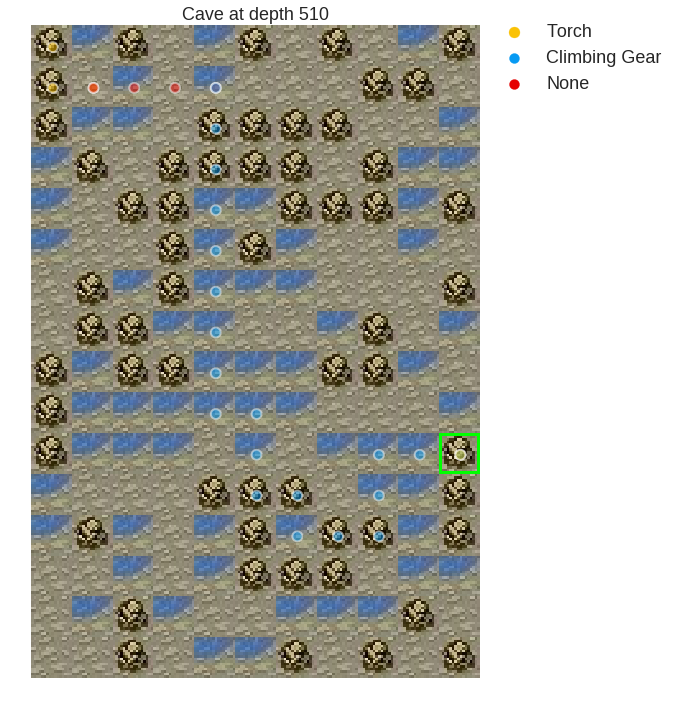

In [4]:
#@title Toy example from the problem description
print('Risk of the cave:', get_risk(10, 10, 510))
path = find_shortest_path(10, 10, 510, offset=(0, 5))
display(10, 10, 510, path[::-1], offset=(0, 5))

In [6]:
#@title Solution on my input
%%time
print('Risk of the cave:', get_risk(7, 721, 9171))
path = find_shortest_path(7, 721, 9171, offset=(45, 0))
#display(7, 721, 9171, path[::-1], offset=(45, 0), figsize=(15, 800))

Risk of the cave: 5786
Rescued in 986 minutes!
CPU times: user 8.55 s, sys: 1.8 ms, total: 8.55 s
Wall time: 8.62 s
